In [3]:
%matplotlib notebook
import os
import numpy as np
import chaospy as cp
import pandas as pd
import seaborn as sns
import itertools
import pickle
from numpy import linalg as LA
from matplotlib import pyplot as plt,cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)

In [4]:
### some global settings
pltlinestyles = [ (0, (1, 5)),(0, (3, 5, 1, 5)),(0, (5, 5)),(0, ()), (0, (3, 1, 1, 1, 1, 1)), 
        (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (3, 10, 1, 10, 1, 10)),(0, (1, 10)), 
        (0, (5, 1)),  (0, (3, 1, 1, 1)),(0, (3, 5, 1, 5, 1, 5)),  (0, (1, 1))  ]*10

pltmarkers =['o','v','s','d','+','*']
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])
pltcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
figsize = (4*1.5,3*1.5)

pf1year    = 1/(1 *365.25*24*3600/1000)
pf5year    = 1/(5 *365.25*24*3600/1000)
pf10year   = 1/(10*365.25*24*3600/1000)
prob_fails = [pf1year, pf5year, pf10year]
print(10.0/pf10year)
print('{:.0e}'.format(10.0/pf10year))

3155760.0
3e+06


## Benchmark


$g(x) = (n+a\sigma \sqrt{n}) - \sum_{i=1}^n x_i $

In [99]:
import scipy
def g(x, n, a=3, sigma=0.2):
    """
    x shape [ndim, nsamples]
    """
    y = n+a*sigma*np.sqrt(n) - np.sum(x, axis=0)
    return y

(2, 16)


<IPython.core.display.Javascript object>


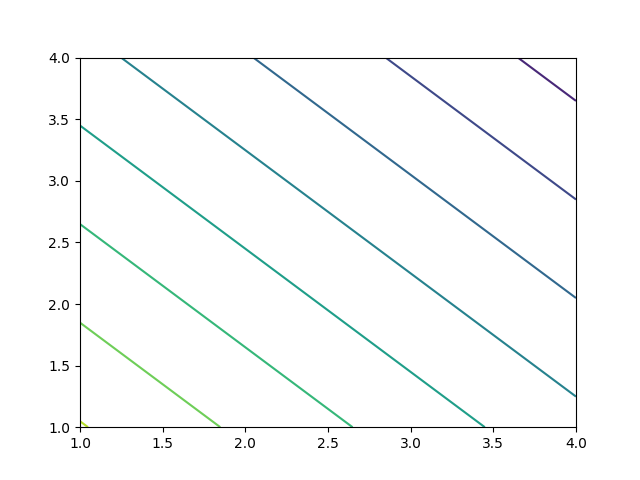

[[ True False False False]
 [False False False False]
 [False False False False]
 [False False False False]]


In [107]:
x = np.arange(0,5,1)[1:]
y = np.arange(0,5,1)[1:]
xx,yy = np.meshgrid(x, y)
x = xx.reshape(1,-1)
y = yy.reshape(1,-1)
xy = np.concatenate((x,y), axis=0)
print(xy.shape)
y = g(xy, 2)
y = y.reshape(xx.shape)
plt.figure()
plt.contour(xx, yy,y)
print(y>0)

In [102]:
n, mu, sigma = 2, 1, 0.2

n_samples = int(1e6)
x = scipy.stats.lognorm.rvs(sigma,scale=np.exp(mu), size=(n,n_samples))
print(np.mean(np.log(x),axis=1))
print(np.std(np.log(x),axis=1))

print(x.shape)
gx = g(x,n,sigma=sigma)
print(gx)
pf = np.sum(gx<0)/n_samples
print(np.around(pf,10))

[1.00010342 0.99981675]
[0.20016356 0.20011076]
(2, 1000000)
[-2.9787334  -3.88363382 -2.19989466 ... -2.26239776 -2.36664575
 -3.30789007]
0.999997


In [119]:
def g(x,c):
    x  = np.array(x)
    x1,x2 = x
    g1 = c-1-x2+np.exp(-x1**2/10)+ (x1/5)**4
    g2 = c**2/2 - x1*x2
    return np.minimum(g1,g2)

In [132]:
c, mu, sigma = 3, 0, 1
n_samples = np.logspace(2, 5,10,dtype=np.int)
pf_mean = []
pf_cov  = []
for isamples in n_samples:
    pf_ = []
    for _ in range(100):
        x = scipy.stats.norm.rvs(loc=0,scale=sigma, size=(2,isamples))
        gx= g(x, c)
        pf_.append(np.sum(gx<0)/isamples)
    pf_mean.append(np.mean(pf_))
    pf_cov.append(np.std(pf_)/abs(np.mean(pf_))) 
    

<IPython.core.display.Javascript object>


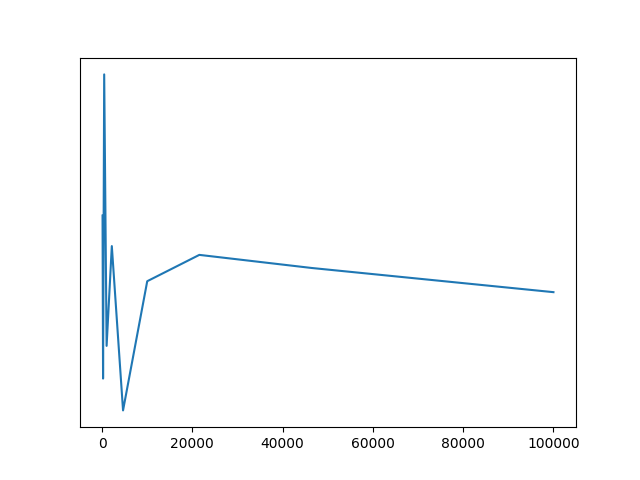

In [136]:
plt.figure()
plt.plot(n_samples, pf_mean)
# plt.plot(n_samples, pf_cov)
plt.yscale('log')

$f(x) =x , x\sim N(0,1)$

In [15]:
from scipy.stats import norm
### Brute monte carlo
n_samples = int(1e)
x_p = norm.rvs(0,1,n_samples)
mu  = np.mean(x_p)
sigma = np.std(x_p)
print(mu, sigma)

0.0003380878325722038 0.9999118271544646


In [56]:
n_samples = int(1e7)
mu, sigma = 0,np.arange(np.sqrt(0.5),5,1)[1:]
# mu, sigma = 0,np.array([1])
sigma_q_analytical = sigma/(2-sigma**-2)**1.5
mu_hat = []
sigma_hat = []
for isigma in sigma:    
    x_q = norm.rvs(mu, isigma,n_samples)
    w   = norm.pdf(x_q, 0,1)/norm.pdf(x_q, mu, isigma)
    mu_hat.append(np.mean(x_q*w))
    sigma_hat.append(np.std(x_q*w))


<IPython.core.display.Javascript object>


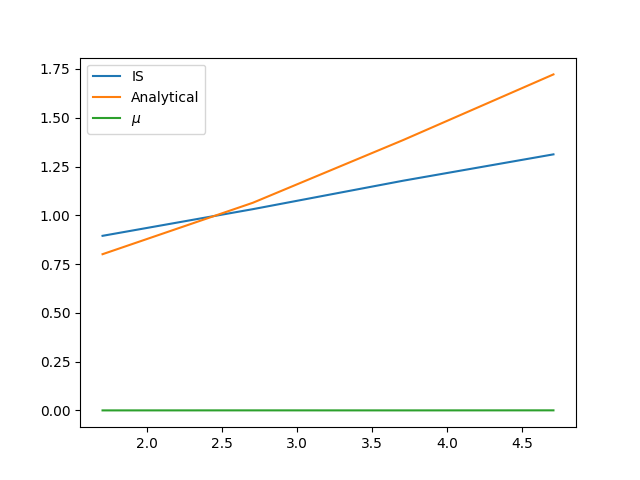

In [57]:
plt.figure()
plt.plot(sigma, sigma_hat, label='IS')
plt.plot(sigma, sigma_q_analytical, label='Analytical')
plt.plot(sigma, mu_hat, label = r'$\mu$')
# plt.plot([0,5],[0,0])
plt.ylim()
plt.legend()

None None
0.0 0.5


<IPython.core.display.Javascript object>


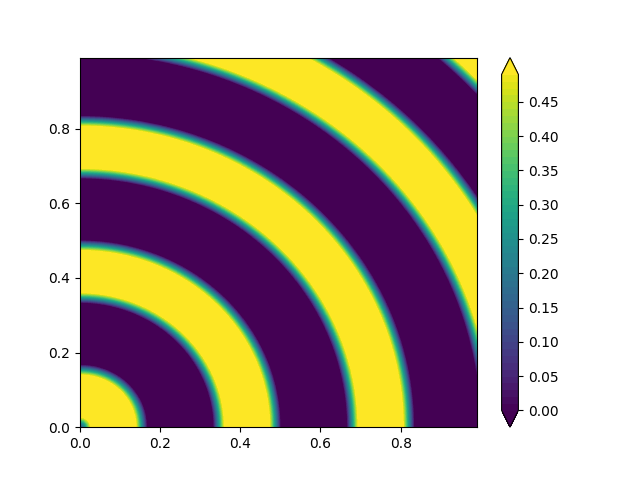

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mplc

x, y = np.mgrid[0:1:0.01, 0:1:0.01]
r = np.sqrt(x ** 2 + y ** 2)
z = np.sin(6 * np.pi * r)

norm = mplc.Normalize()
print(norm.vmin, norm.vmax)

norm = mplc.Normalize(0, 0.5)
print(norm.vmin, norm.vmax)
fig0, ax0 = plt.subplots(1, 1, )
cf0 = ax0.contourf(x, y, z, np.arange(0, .5, .01), norm=norm,
                   extend='both', cmap='viridis')
cbar0 = plt.colorbar(cf0,)